# Dynamics of the Izhikevich Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.signal import argrelmax

def reset(p, v, u, i):
    """resets the values for v and u at a given index"""
    v[i] = p['c']
    u[i] += p['d']
    
def neuron(p, I, t_max, dt):
    """ returns the membrane potential and the recovery variable u during a given time approximated with the euler method 
    p : dictionary, contains the parameters a, b, c, d
    I : function, I(t) is the current at time t in pA
    t_max : float, time length of the simulation in ms
    dt : float, time step in ms
    """
    # create arrays for t, u, v and set initial values
    t = np.arange(0, t_max, dt)
    u = np.zeros((len(t),1))
    u[0] = 0
    v = np.zeros((len(t),1))
    v[0] = -80
    for i in range(len(t)-1):
        if v[i] >= 30:
            reset(p, v, u, i)
        u[i+1] = u[i] + dt * p['a'] * (p['b'] * v[i] - u[i])
        v[i+1] = v[i] + dt * (0.04 * (v[i])**2 + 5 * v[i] + 140 - u[i] + I(t[i])) 
    return t, v, u

def find_spikes(v):
    """returns the indices of spikes in a given simulation array v"""
    extrema = argrelmax(v)
    return np.extract(v[extrema] > 0, extrema) # exclude maxima that are not spikes

def neuron_fires(p, I, t_max=300, dt=0.2):
    """returns whether the neuron fires with parameters p and current I or not"""
    t, v, _ = neuron(p, I, t_max, dt)
    return len(find_spikes(v)) > 1

def find_threshold(p, acc):
    """finds the threshold needed for the neuron to fire with a given accuracy"""
    # setup arbitray binary search borders
    lower = 0
    upper = 100
    while upper - lower >= acc:
        mid = (lower + upper) / 2
        I = lambda t : mid
        if neuron_fires(p, I):
            upper = mid
        else:
            lower = mid
    return upper
    
def firing_rate(current, p, t_max=200):
    """computes the firing rate in kHz given an input current I and parameters p"""
    dt = 0.1
    I = lambda t : current
    t, v, _ = neuron(p, I, t_max, dt)
    if np.max(v) < 0: # no spikes
        return 0.0 # return float in any case
    else:
        spikes = find_spikes(v)
        if len(spikes) <= 1:
            return 0.0
        else:
            return (len(spikes)-1) / (dt * (spikes[-1] - spikes[0]))

## Integrator model

In [3]:
# 1. integrator model
p1 = {
    'a': 0.1,
    'b': 0.05,
    'c': -50,
    'd': 8
}
# determine threshold
I_thresh = find_threshold(p1, 0.001)
print(f'The minimum current needed to activate the neuron is about {np.round(I_thresh, 3)} mA.')

The minimum current needed to activate the neuron is about 13.146 mA.


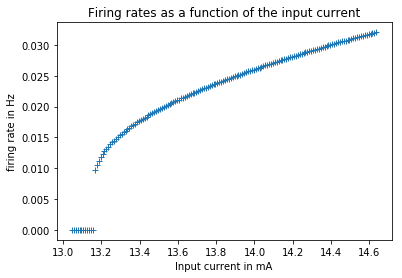

In [4]:
# setup current range and plot firing rates
currents = np.arange(I_thresh-0.1, I_thresh + 1.5, 0.01)
firing_rates = np.vectorize(firing_rate)(currents, p1)

plt.plot(currents, firing_rates, '+')
plt.title('Firing rates as a function of the input current')
plt.xlabel('Input current in mA')
plt.ylabel('firing rate in Hz')
plt.show()

$\Longrightarrow$ The integrator model has typical firing rates for a type 1 neuron.

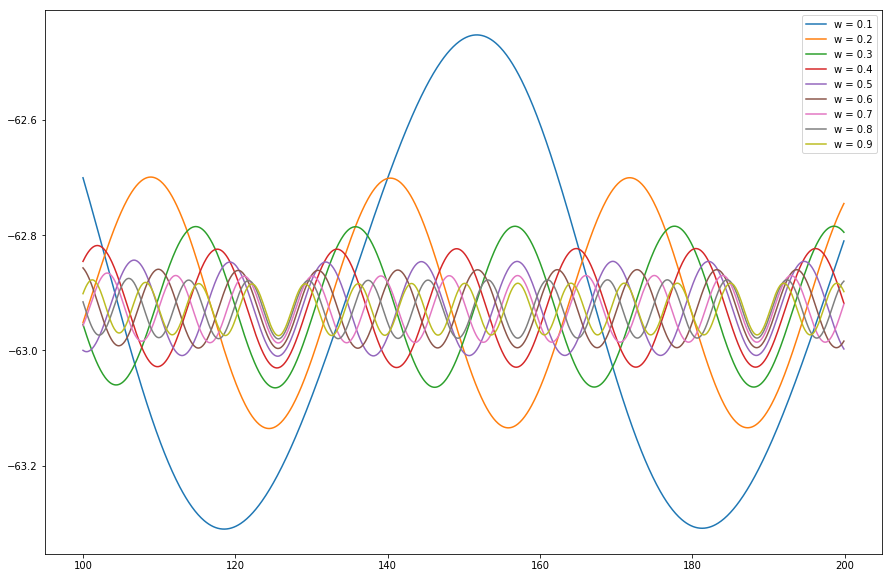

In [5]:
# sinusodial input current
def sinusoidal_current(w, I_thresh):
    return lambda t : I_thresh - 0.05 + 0.04 * np.sin(w*t)

def sinusoidal_neuron(p, omegas, t_max, dt, I_thresh):
    """simulates a neuron with sinusoidal current
    p : paramters for the simulation
    omegas: array with values for w
    t_max, dt : length of simulation and time step
    I_thresh : current threshold to activate neuron
    returns time array and a list of voltage data"""
    simulations = []
    for i in range(len(omegas)):
        w = omegas[i]
        I = sinusoidal_current(w, I_thresh)
        t, v, _ = neuron(p, I, t_max, dt)
        simulations.append(v)
    return np.arange(0, t_max, dt), simulations

# simulation with sinusoidal current
t_max = 200
dt = 0.1
omegas = np.arange(0.1, 1, 0.1)
I_thresh = find_threshold(p1, 0.001)

# plot
fig = plt.figure(figsize=(15,10))
t, simulations = sinusoidal_neuron(p1, omegas, t_max, dt, I_thresh)
for i in range(len(omegas)):
    plt.plot(t[1000:], simulations[i][1000:], label=f'w = {np.round(omegas[i], 3)}')
plt.legend()
plt.show()

The voltage can be approximate with $v(t) \approx v_0 + A( \omega ) \sin (\omega t - \varphi)$.


Given the plot we may take an educated guess for the transfer function. The amplitudes are decreasing as $\omega$ increases. We may guess

$$A( \omega ) = \frac{1}{c \cdot \omega}, \ where \ c \in \mathbb{R}.$$

We'll show that this approximation is a good one. However, it should be noted that there are other functions that would approximate the transfer function just as good or even better. Our approximation is not good for very small values of $\omega$, as the amplitude will never exceed 0.5.

In [6]:
def amplitude(V):
    """returns the amplitude of a given sinusoidal signal V"""
    return (np.max(V)-np.min(V)) / 2

def A(c):
    return lambda w : 1/(c * w)

def transfer(p, acc, t_max, w_max, dt, dw, I_thresh):
    """approximates c for the transfer function up to a given accuracy
    returns c (float) and the amplitudes(2d array)"""
    # simulate neuron for various values of omega
    omegas = np.arange(0+dw, w_max, dw)
    t, simulations = sinusoidal_neuron(p, omegas, t_max, dt, I_thresh)
    amplitudes = np.zeros((2, len(omegas)))
    for i in range(len(omegas)):
        amplitudes[0][i] = omegas[i]
        amplitudes[1][i] = amplitude(simulations[i][1000:])
    # setup binary search
    lower = 0
    upper = 20
    while upper - lower >= acc:
        mid = A((lower + upper) / 2)
        if np.sum(mid(amplitudes[0]) - amplitudes[1]) > 0: # no need for squares
            lower = (lower + upper) / 2
        else:
            upper = (lower + upper) / 2
    return lower, amplitudes

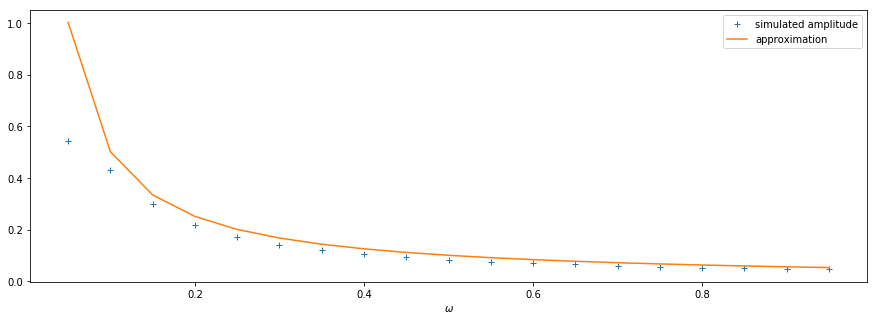

In [7]:
# plot transfer function against the simulated amplitudes
I_thresh = find_threshold(p1, 0.001)
t_max = 1000
w_max = 1
dt = 0.1
dw = 0.05
omegas = np.arange(0 + dw, w_max, dw)
c, amps = transfer(p1, 0 + dw, t_max, w_max, dt, dw, I_thresh)
fig = plt.figure(figsize=(15,5))
plt.plot(amps[0], amps[1], '+', label='simulated amplitude')    
plt.plot(omegas, A(c)(omegas), label='approximation')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

## Resonator model

In [8]:
# 2. resonator model
p2 = {
    'a': 0.1,
    'b': 0.26,
    'c': -65,
    'd': 2
}

# calculate and plot threshold
# determine threshold
I_thresh2 = find_threshold(p2, 0.01)
print(f'The minimum current needed to activate the neuron is about {np.round(I_thresh2, 3)} mA.')

The minimum current needed to activate the neuron is about 0.146 mA.


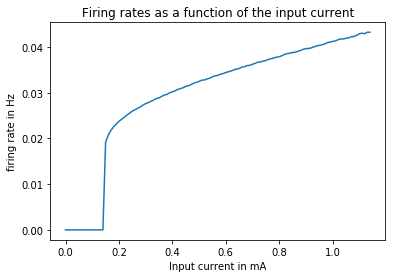

In [9]:
# setup current range and plot firing rates
t_max = 400
dt  = 0.01
currents = np.arange(0, I_thresh2 + 1, 0.01)
firing_rates = np.vectorize(firing_rate)(currents, p2)

plt.plot(currents, firing_rates)
plt.title('Firing rates as a function of the input current')
plt.xlabel('Input current in mA')
plt.ylabel('firing rate in Hz')
plt.show()

// It seems like the threshold should be around 0.16.

$\Longrightarrow$ The resonator model shows type 2 firing rates.

In [10]:
I_thresh2 = find_threshold(p2, 0.001)
t_max = 300
w_min = 0.0
w_max = 0.9
dt = 0.1
dw = 0.05
omegas = np.arange(w_min, w_max, dw)

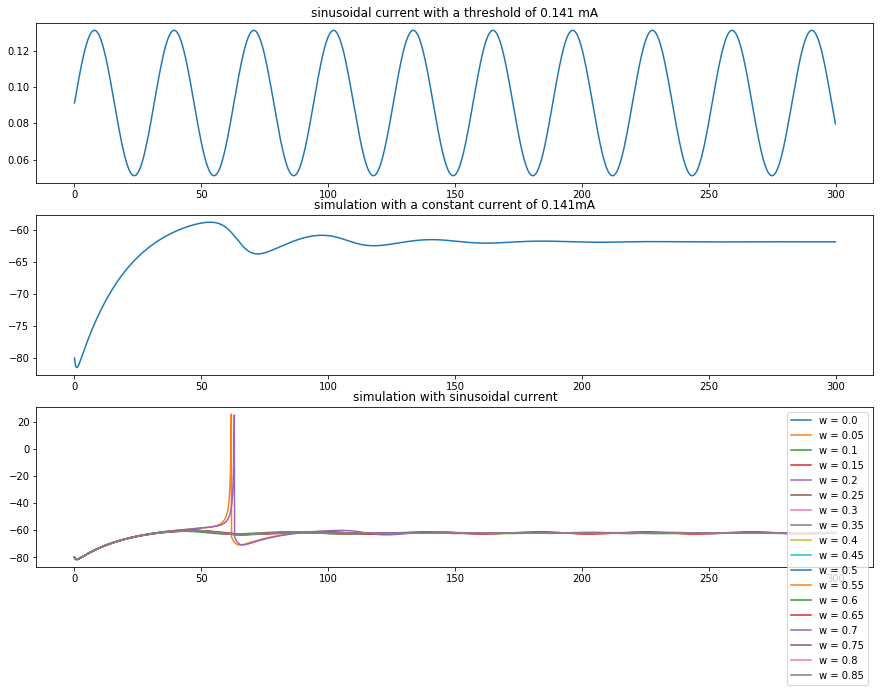

In [11]:
I = lambda t : I_thresh2
t, v, _ = neuron(p2, I, t_max, dt)
c = sinusoidal_current(.2, I_thresh2)
curr = np.vectorize(c)(t)
t, simulations = sinusoidal_neuron(p2, omegas, t_max, dt, I_thresh2+0.02)

# plot current and simulations
fig, ax = plt.subplots(3,1, figsize = (15,10))
ax[0].title.set_text(f'sinusoidal current with a threshold of {np.round(I_thresh2, 3)} mA')
ax[0].plot(t, curr)
ax[1].title.set_text(f'simulation with a constant current of {np.round(I_thresh2, 3)}mA')
ax[1].plot(t, v)
ax[2].title.set_text('simulation with sinusoidal current')
for i in range(len(omegas)):
    ax[2].plot(t, simulations[i], label=f'w = {np.round(omegas[i], 3)}')
ax[2].legend()
plt.show()

## 3

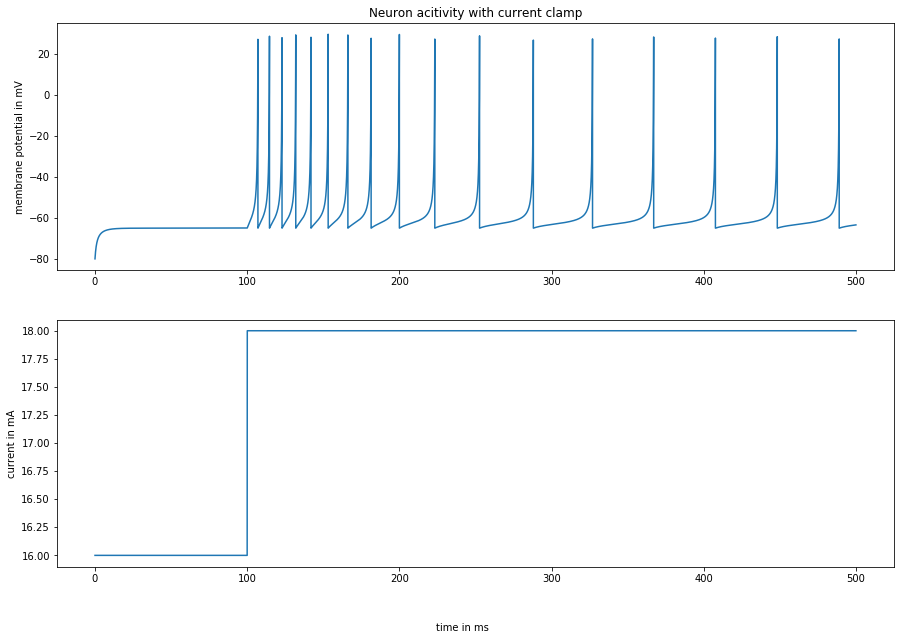

In [12]:
p3 = {
    'a': 0.003,
    'b': 0,
    'c': -65,
    'd': 0.2
}
def step_function(levels, t_max, dt):
    """generates a clamped current function
    levels : dict
        entries are t: c, where t is the time when the current is set to c
        t=0 is preliminary, following entries should be sorted by time.
    t_max : int
        time in ms that the neuron should be simulated
    dt : float
        time step
    """
    # iterate over levels and populate current array
    sortedLevels = sorted(list(levels.items()))
    c = sortedLevels[0][1] * np.ones((int(t_max/dt),1))
    for key, val in sortedLevels:
        if key != 0:
            c[(int(int(key)/dt)):] = val
    return lambda t : c[int(t/dt)]

# simulation with step current
t_max = 500
dt = 0.01
currents3 = {
    0: 16,
    100: 18,
}
I_3 = step_function(currents3, t_max, dt)
t, v, u = neuron(p3, I_3, t_max, dt)
current = np.vectorize(I_3)(t)
# plot
# plot
fig, ax = plt.subplots(2,1, figsize = (15,10))
ax[0].title.set_text('Neuron acitivity with current clamp')
fig.text(0.5, 0.04, 'time in ms', ha='center', va='center')
ax[0].plot(t, v)
ax[0].set_ylabel('membrane potential in mV')
ax[1].plot(t, current)
ax[1].set_ylabel('current in mA')
plt.show()

<IPython.core.display.Javascript object>


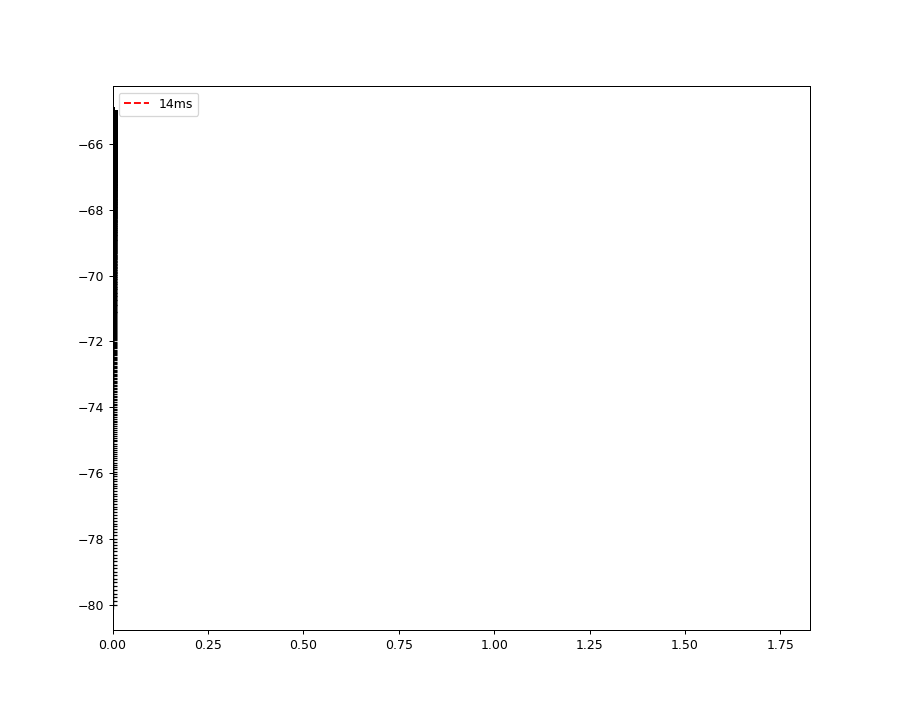

In [18]:
%matplotlib notebook
import matplotlib.animation as animation

# simulation with step current
t_max = 500
dt = 0.01
currents3 = {
    0: 16,
    100: 18,
}
I_3 = step_function(currents3, t_max, dt)
t, v, u = neuron(p3, I_3, t_max, dt)

# create figure
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_ylim(np.min(v), 1.1 * np.max(v))
ax1.set_xlabel('u',fontsize=10)
ax1.set_ylabel('v in mV',fontsize=10)
plt.title('Phase plane',fontsize=20)

# create animation
def animate(i):
    if i == 0:
        pass
    ax1.clear()
    ax1.set_xlim(np.min(u), 1.05 * np.max(u))
    ax1.plot(u[:(i-1)*200], v[:(i-1)*200], 'k+')
    ax1.plot(u[(i-1)*200:i*200], v[(i-1)*200:i*200], 'r--', label=f'{i}ms')
    ax1.legend(loc='upper left')

ani = animation.FuncAnimation(fig, animate, frames=250, repeat=True)

# save animation
Writer = animation.writers['imagemagick']
writer = Writer(fps=25, bitrate=900)

ani.save('.//phase_plane3.gif', writer=writer)
plt.show()

## Chattering neuron model

<IPython.core.display.Javascript object>


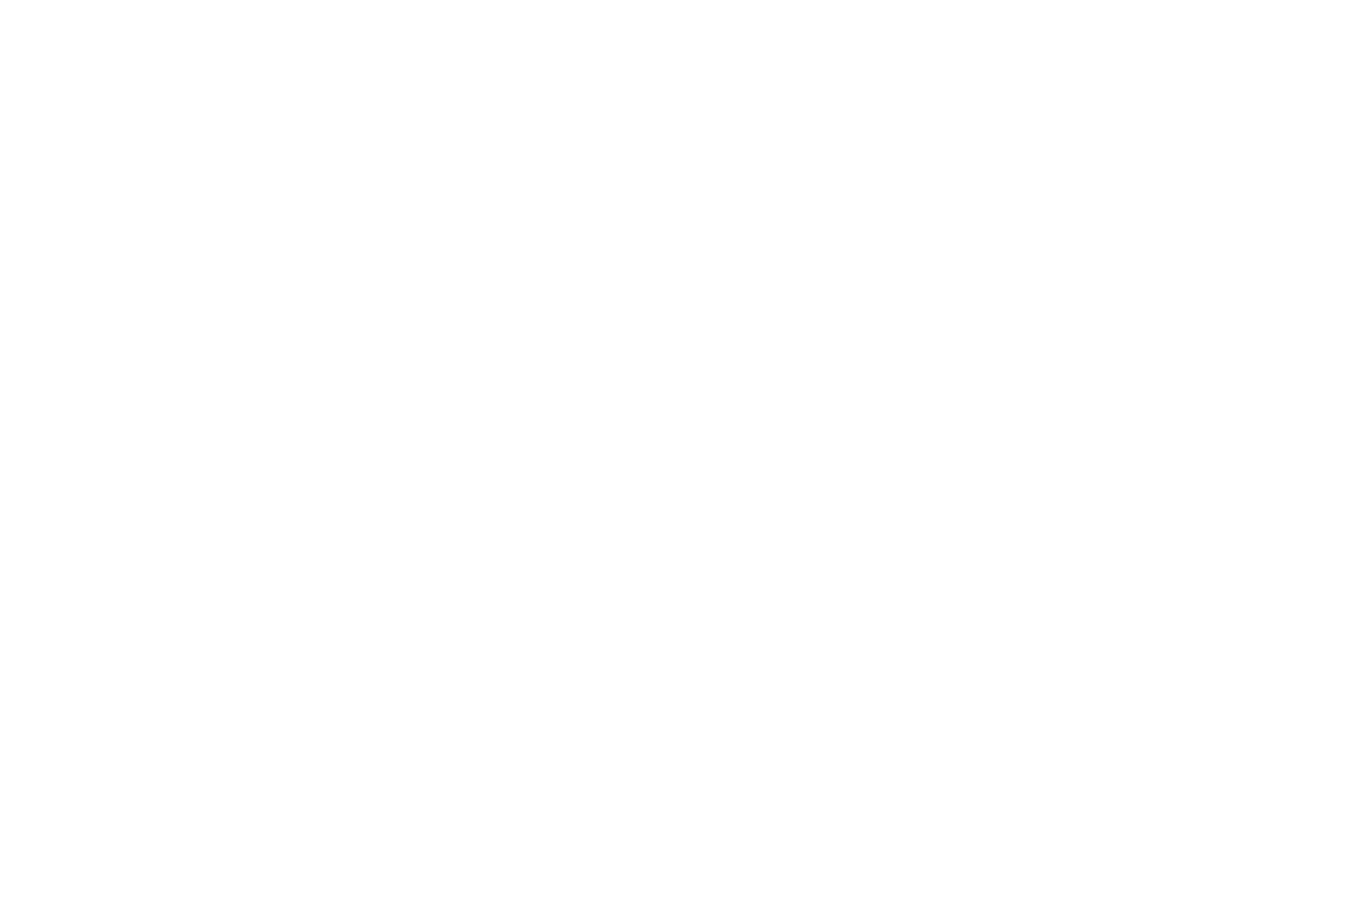

<IPython.core.display.Javascript object>


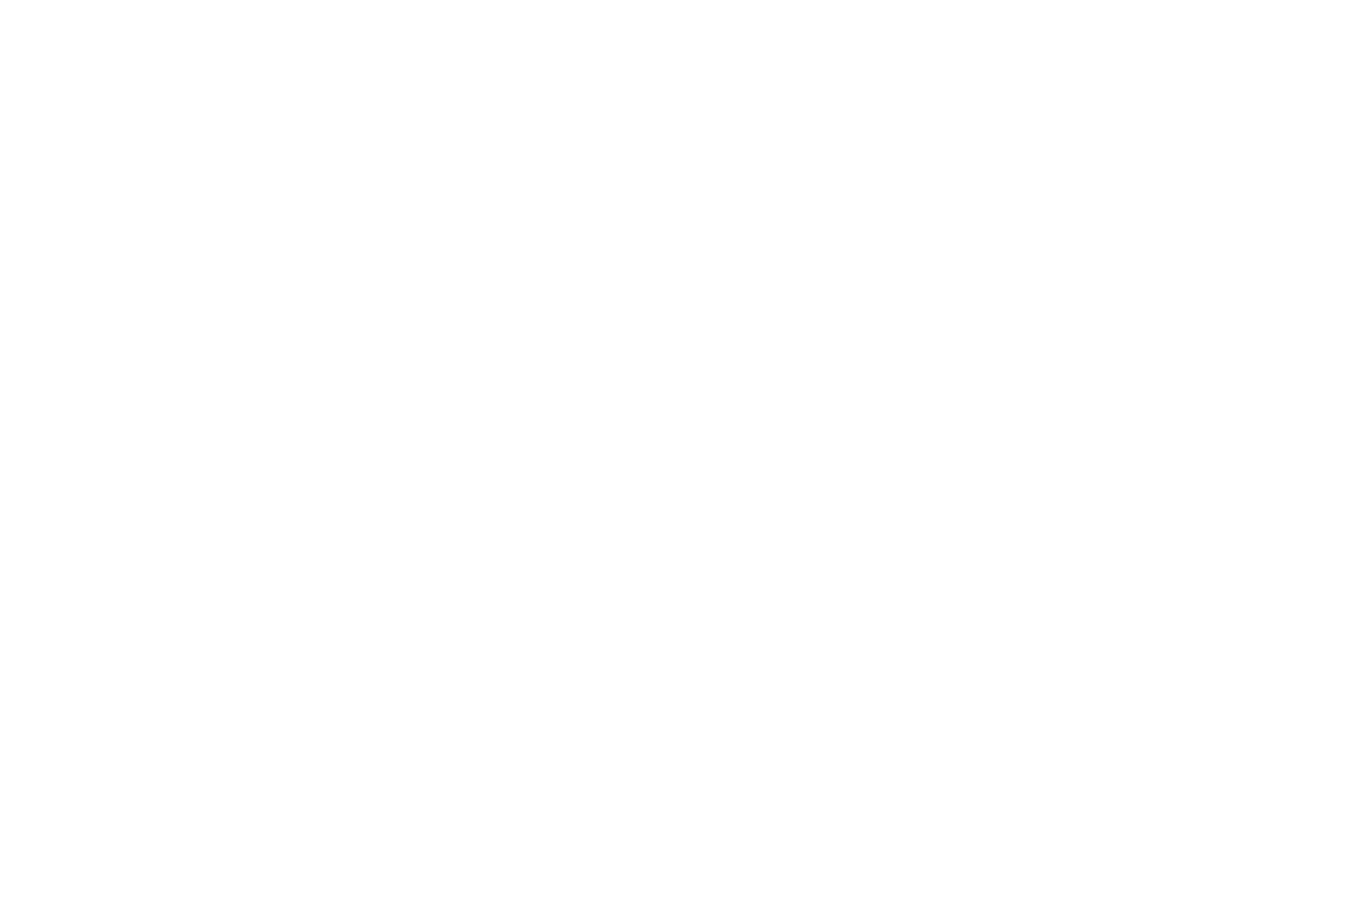

In [14]:
def chattering_neuron(p, d, I, t_max, dt):
    """ returns the membrane potential during a given time approximated with the euler method
    simulation with a decreasing parameter d
    p : dictionary, contains the parameters a, b, c
    d : function of the d values(float) in time
    I : function, I(t) is the current at time t in pA
    t_max : float, time length of the simulation in ms
    dt : float, time step in ms
    """
    # create arrays for t, u, v and set initial values
    t = np.arange(0, t_max, dt)
    u = np.zeros((len(t),1))
    u[0] = 0
    v = np.zeros((len(t),1))
    v[0] = -80
    for i in range(len(t)-1):
        if v[i] >= 30:
            chattering_reset(p, d, v, u, i, dt)
        u[i+1] = u[i] + dt * p['a'] * (p['b'] * v[i] - u[i])
        v[i+1] = v[i] + dt * (0.04 * (v[i])**2 + 5 * v[i] + 140 - u[i] + I(t[i])) 
    return t, v

def chattering_reset(p, d, v, u, i, dt):
    """resets the values for v and u at a given index, d is dynamically updated"""
    v[i] = p['c']
    u[i] += d(i*dt)
    
# simulate with decreasing reset parameter d
p4 = {
    'a': 0.02,
    'b': 0.2,
    'c': -50,
}
d_dict = {
    0 : 8,
    150: 6,
    300: 4,
    450: 2
}
t_max = 600
dt = 0.01
d = step_function(d_dict, t_max, dt)
I_4 = lambda t : 5
t, v = chattering_neuron(p4, d, I_4, t_max, dt)
d_array = np.vectorize(d)(t)
# plot
fig, ax = plt.subplots(2,1, figsize = (15,10))
ax[0].title.set_text('Neuron activity with decreasing reset parameter')
fig.text(0.5, 0.04, 'time in ms', ha='center', va='center')
ax[0].plot(t, v)
ax[0].set_ylabel('membrane potential in mV')
ax[1].plot(t, d_array)
ax[1].set_ylabel('reset parameter d')
plt.show()

In [15]:
a = np.arange(0,10,1)
print(a[2:])

[2 3 4 5 6 7 8 9]
